In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,random_split, Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from model import *
import tqdm

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [7]:
def create_dataset(number:int = None):
    download_root = './MNIST_DATASET'
    train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
    test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
    if number is not None:
        targets = train_dataset.targets.numpy()
        t_idx = np.where(targets==number)[0]
        train_dataset = Subset(train_dataset, t_idx)
        targets = test_dataset.targets.numpy()
        t_idx = np.where(targets==0)[0]
        t_idx1 = np.where(targets==1)[0]
        # t_idx2 = np.where(targets==6)[0]
        test_dataset = Subset(test_dataset, np.concatenate((t_idx,t_idx1),axis=None))
        
    batch_size = 128 
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataset, test_dataset, train_loader, test_loader

In [4]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = []
    for image_batch, _ in dataloader: 
        image_batch = image_batch.to(device)
        reconstructed = model(image_batch)
        loss = loss_fn(reconstructed, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): 
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            reconstructed = model(image_batch)
            conc_out.append(reconstructed.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


def plot_ae_outputs(model,test_dataset,n=10,name=None,num=0):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      model.eval()
      with torch.no_grad():
         rec_img  = model(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    if name:
        plt.savefig(f'images/{name}_{num}.png')
    plt.show() 

In [5]:
def init_model(latent_dim = 1):
    loss_fn = torch.nn.MSELoss()
    model = Autoencoder(latent_dim).to(device)
    params_to_optimize = model.parameters()
    optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
    return loss_fn, model, optim

In [39]:
num_epochs = 50
for number in range(0,1):
   train_dataset, test_dataset, train_loader, test_loader = create_dataset()
   dim = 2
   loss_fn, model, optim = init_model(latent_dim = dim)
   min_loss = np.inf
   diz_loss = {'train_loss':[],'val_loss':[]}
   for epoch in range(num_epochs):
      train_loss = train_epoch(model,device,train_loader,loss_fn,optim)
      val_loss = test_epoch(model,device,test_loader,loss_fn)
      
      if val_loss < min_loss :
         opt_model = model
         best_epoch = epoch
      diz_loss['train_loss'].append(train_loss)
      diz_loss['val_loss'].append(val_loss)
      plot_ae_outputs(opt_model,test_dataset,n=10,name='unpooling', num=dim)
      
   print(f"epoch : {best_epoch}, Val_loss : {np.min(diz_loss['val_loss'])}")
   save_dict = {
      "model" : opt_model.state_dict(),
      "loss" : diz_loss
   }
   torch.save(save_dict, f'model/number_{number}')
   

KeyboardInterrupt: 

In [45]:
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
for number in range(10):
    targets = train_dataset.targets.numpy()
    t_idx = np.where(targets==number)[0]
    print(f'len({number}) : {len(t_idx)}')

len(0) : 5923
len(1) : 6742
len(2) : 5958
len(3) : 6131
len(4) : 5842
len(5) : 5421
len(6) : 5918
len(7) : 6265
len(8) : 5851
len(9) : 5949


In [13]:
print(np.min(torch.load(f'model/Convtranspose_0')['loss']['val_loss']))
print(np.min(torch.load(f'model/Upsample_0')['loss']['val_loss']))

0.21219929
0.21273543


In [8]:
_, model, _ = init_model(latent_dim = 2)
saved_dict = torch.load(f'model/dim_2')
model.load_state_dict(saved_dict["model"], strict=False)  

train_dataset, test_dataset, train_loader, test_loader = create_dataset(1)

# targets = train_dataset.targets.numpy()
# t_idx = np.where(targets==number)[0]
# train_dataset = Subset(train_dataset, t_idx)


encoded_samples = []
for sample in tqdm.tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 2115/2115 [00:01<00:00, 1252.99it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,-0.749036,-0.095732,0
1,-0.896165,-0.345161,0
2,-0.712768,-0.253477,0
3,-1.935875,0.232790,0
4,-0.618978,-0.154302,0
...,...,...,...
2110,0.615709,-0.215477,1
2111,0.547040,-0.265438,1
2112,0.623325,-0.182053,1
2113,0.495115,-0.591364,1


In [9]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [61]:
import plotly.express as px

px.scatter_3d(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
           color=encoded_samples.label.astype(str), opacity=0.7)

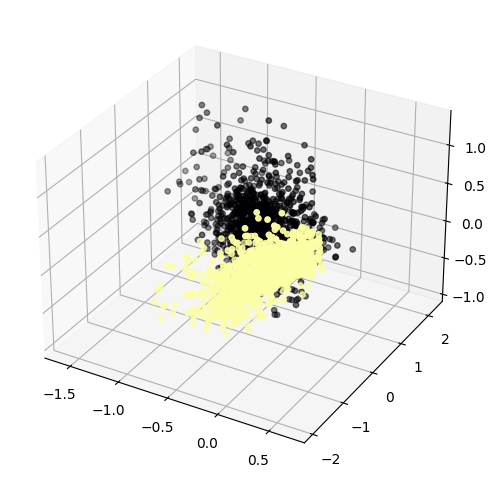

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_samples['Enc. Variable 0'],encoded_samples['Enc. Variable 1'],encoded_samples['Enc. Variable 2'], 
           c=encoded_samples['label'], marker='o', s=15, cmap='inferno')

In [1]:
from plotly.offline import plot
import plotly.graph_objs as go

color = encoded_samples['label']
data = go.Scatter3d(
    x=encoded_samples['Enc. Variable 0'],
    y=encoded_samples['Enc. Variable 1'],
    z=encoded_samples['Enc. Variable 2'],
    mode='markers',
    marker=dict(
        size=3,
        color=color,
        colorscale='Jet',
        line=dict(
            #color='rgba(217, 217, 217, 0.14)',
            #color='rgb(217, 217, 217)',
            width=0.0
        ),
        opacity=0.8
    )
)
layout = go.Layout(
    showlegend=True,
    autosize=False,
    width=500,
    height=500,
    margin=go.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    #paper_bgcolor='#7f7f7f',
    #plot_bgcolor='#c7c7c7'
)
fig = go.Figure(data=[data], layout=layout)
fig.show()


NameError: name 'encoded_samples' is not defined